In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import xarray as xr
from scipy.interpolate import interpn
import cmocean as cm
import matplotlib.colors as colors
import math
from matplotlib.gridspec import GridSpec

## import data

In [3]:
# summary data already has all the info you need for what your're using
up =  pd.concat([pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2013.csv').assign(year=2013),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2014.csv').assign(year=2014),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2015.csv').assign(year=2015),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2016.csv').assign(year=2016),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2017.csv').assign(year=2017),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2018.csv').assign(year=2018),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2020.csv').assign(year=2020),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2021.csv').assign(year=2021),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2022.csv').assign(year=2022)])

dw = pd.concat([pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2014.csv').assign(year=2014),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2016.csv').assign(year=2016),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2017.csv').assign(year=2017),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2018.csv').assign(year=2018),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2020.csv').assign(year=2020),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2021.csv').assign(year=2021),
        pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2022.csv').assign(year=2022)])


In [4]:
# all the data (not sorted into sources)
updata = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/upwellingdata.csv')
dwdata = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/downwellingdata.csv')


In [5]:
# length of difffernet periods in days
lup = [219, 161, 144, 158, 156,128,244,189, 117] 
ldw = [113, 149, 198, 91, 53, 82, 105]

In [6]:
updata.head()

,Unnamed: 0,year,section,depth,lon,lat,transport,salt,temperature,NO3,DO,TA,DIC
0,0,2013.0,0.0,12.522161,-124.379045,48.293956,26.206773,29.139933,7.992830,12.914421,290.669708,2113.837402,1976.673462
1,1,2013.0,0.0,25.202893,-124.379045,48.297176,69.694170,29.316879,7.836041,16.807518,283.115295,2116.144775,2000.621826
2,2,2013.0,0.0,4.563025,-124.379045,48.325483,36.442395,28.625412,7.993061,9.992110,307.096863,2093.907715,1939.443481
3,3,2013.0,0.0,13.537883,-124.379045,48.290274,40.103976,28.676762,8.040707,11.207986,300.486847,2094.389648,1949.883667
4,4,2013.0,0.0,30.177724,-124.379045,48.298656,55.086125,29.962944,7.780801,19.743525,266.137146,2144.134033,2042.130737


In [7]:
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

mymesh = xr.open_dataset('/data1/bbeutel/LO_output/grid/grid_cas7.nc')
def FluxEW_ROMS(mydata, boolean,y, xmin, xmax, days, ax):
    
    units = '$m^3 \, s^{-1} m^{-2}$'
    m2lon=1.6691435255493834*(10**-5)
    maxdepth = 500

    time = np.sum(days)*24

    cmap = cm.cm.speed
    cmap.set_under('white')
    
    depths = mydata.depth[boolean]
    transports = mydata.transport[boolean]/time
    lons = mydata.lon[boolean]
    
    t_min = 0.000000000001
    tick = 0.01
    t_max = (tick/np.sum(transports))/m2lon
        
    H, xedges, yedges, im = ax.hist2d(lons, depths, bins=[np.array(mymesh.lon_rho[y,xmin-1:xmax+1]), 
                                    np.arange(0,np.max(mymesh.h[y,xmin:xmax]),10)],weights= transports, 
                                    cmap=cm.cm.speed, vmin = t_min, vmax=t_max, density= True)
    
    # cb1 = fig.colorbar(im, ax=ax)
    # cb1.set_ticks([0, t_max])
    # cb1.set_ticklabels([0, tick])
    # cb1.set_label(units, labelpad=-20)

    ax.fill_between(mymesh.lon_rho[y,xmin-1:xmax+1],mymesh.h[y,xmin-1:xmax+1], 500, color='lightgray')

    ax.invert_yaxis()
    ax.set_xticks([mymesh.lon_rho[y,xmin+2], mymesh.lon_rho[y,xmax-2]])
    ax.set_xticklabels(np.round([mymesh.lon_rho[y,xmin+2], mymesh.lon_rho[y,xmax-2]],2))
    ax.set_xlim((mymesh.lon_rho[y,xmin], mymesh.lon_rho[y,xmax]))
    ax.set_ylim((maxdepth, 0))
    # full_title = str(round_to_2(np.sum(transports)))[:-2]+" "+units
    # ax.set_title(str(full_title))

## south water masses

In [22]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 26,34.6
tmin, tmax = 4,15
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

        

def TS_depth(df,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df['salinity (g kg-1)'].reset_index(drop=True)
    temp = df['temperature (degC)'].reset_index(drop=True)
    z = df['depth (m)'].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]
                    
    sc = ax.scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Depth [m]', labelpad=10, fontsize=14)

    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

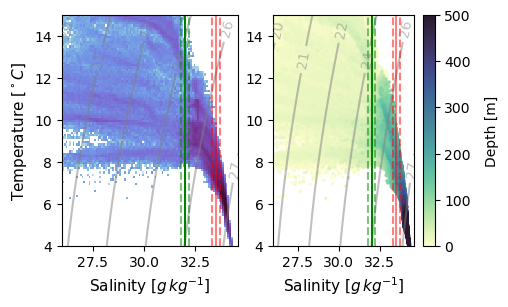

In [23]:
fig, ax = plt.subplots(1,2, figsize=(5,3))
salt, temp, trans, depth = updata[updata.section == 2].salt.reset_index(drop=True), updata[updata.section == 2].temperature.reset_index(drop=True), updata[updata.section == 2].transport.reset_index(drop=True), updata[updata.section == 2].depth.reset_index(drop=True)

# first TS coloured by transport
bins = [np.linspace(26,34.6,100),np.linspace(4,15.01,100)]

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=100000000))
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=11)

# then coloured by depth
cmap = cm.cm.deep
idx = depth.argsort()
salt, temp, depth = salt[idx], temp[idx], depth[idx]
sc=ax[1].scatter(salt,temp,c=depth, cmap=cmap,s=2, vmin=0, vmax=500)
cb = fig.colorbar(sc, ax=ax[1])
cb.set_label('Depth [m]', labelpad=10, fontsize=10)


# add lines to show cutoff
for axs in ax:
    axs.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=11)
    axs.set_ylim([np.min(bins[1]),np.max(bins[1])])
    axs.set_xlim([np.min(bins[0]),np.max(bins[0])])

    CS=axs.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    axs.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    axs.set_ylim([np.min(bins[1]),np.max(bins[1])])
    axs.set_xlim([np.min(bins[0]),np.max(bins[0])])

    axs.plot([33.5,33.5],[np.min(bins[1]),np.max(bins[1])],'r',alpha=0.5)
    axs.plot([33.5-0.2,33.5-0.2],[np.min(bins[1]),np.max(bins[1])],'r--',alpha=0.5)
    axs.plot([33.5+0.2,33.5+0.2],[np.min(bins[1]),np.max(bins[1])],'r--',alpha=0.5)

    axs.plot([32,32],[np.min(bins[1]),np.max(bins[1])],'g')
    axs.plot([32-0.2,32-0.2],[np.min(bins[1]),np.max(bins[1])],'g--',alpha=0.5)
    axs.plot([32+0.2,32+0.2],[np.min(bins[1]),np.max(bins[1])],'g--',alpha=0.5)

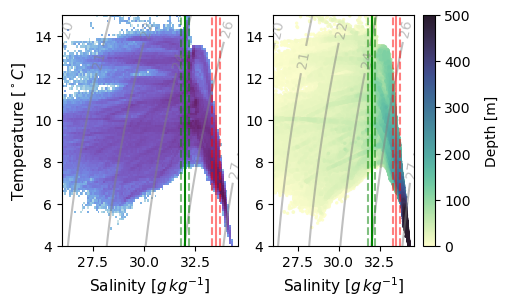

In [24]:
# and for downwelling 
fig, ax = plt.subplots(1,2, figsize=(5,3))
salt, temp, trans, depth = dwdata[dwdata.section == 2].salt.reset_index(drop=True), dwdata[dwdata.section == 2].temperature.reset_index(drop=True), dwdata[dwdata.section == 2].transport.reset_index(drop=True), dwdata[dwdata.section == 2].depth.reset_index(drop=True)

# first TS coloured by transport
bins = [np.linspace(26,34.6,100),np.linspace(4,15.01,100)]

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=100000000))
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=11)

# then coloured by depth
cmap = cm.cm.deep
idx = depth.argsort()
salt, temp, depth = salt[idx], temp[idx], depth[idx]
sc=ax[1].scatter(salt,temp,c=depth, cmap=cmap,s=2, vmin=0, vmax=500)
cb = fig.colorbar(sc, ax=ax[1])
cb.set_label('Depth [m]', labelpad=10, fontsize=10)


# add lines to show cutoff
for axs in ax:
    axs.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=11)
    axs.set_ylim([np.min(bins[1]),np.max(bins[1])])
    axs.set_xlim([np.min(bins[0]),np.max(bins[0])])

    CS=axs.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    axs.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    axs.set_ylim([np.min(bins[1]),np.max(bins[1])])
    axs.set_xlim([np.min(bins[0]),np.max(bins[0])])

    axs.plot([33.5,33.5],[np.min(bins[1]),np.max(bins[1])],'r',alpha=0.5)
    axs.plot([33.5-0.2,33.5-0.2],[np.min(bins[1]),np.max(bins[1])],'r--',alpha=0.5)
    axs.plot([33.5+0.2,33.5+0.2],[np.min(bins[1]),np.max(bins[1])],'r--',alpha=0.5)

    axs.plot([32,32],[np.min(bins[1]),np.max(bins[1])],'g')
    axs.plot([32-0.2,32-0.2],[np.min(bins[1]),np.max(bins[1])],'g--',alpha=0.5)
    axs.plot([32+0.2,32+0.2],[np.min(bins[1]),np.max(bins[1])],'g--',alpha=0.5)

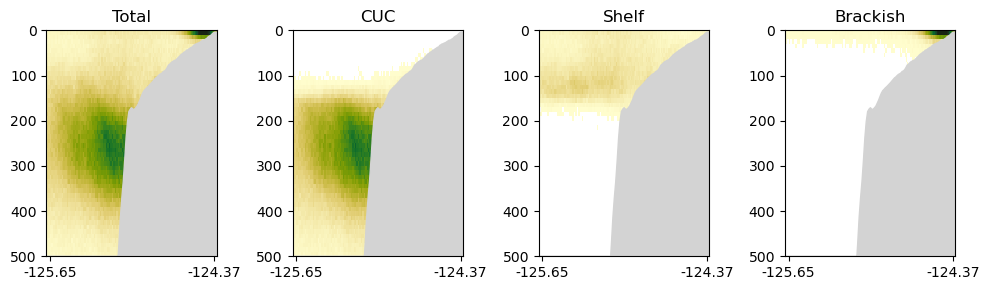

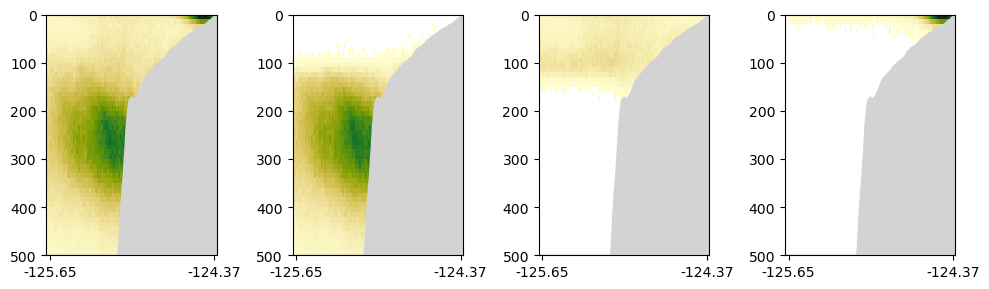

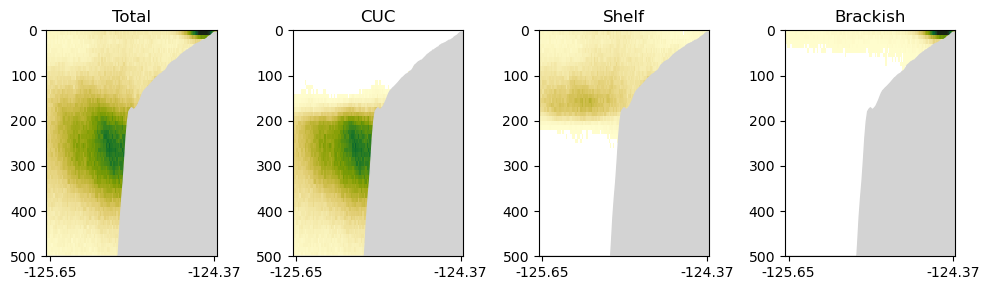

In [25]:
# location of cores of flow 
# UPWELLING
y = 744
xmin=192
xmax=317

############
# original #
############
figure, ax = plt.subplots(1,4,figsize=(10,3))
boolean = (updata.section == 2) #for all south
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[0])
ax[0].set_title('Total')

#try cuc delineation
boolean = (updata.section == 2) & (updata.salt >= 33.5)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[1])
ax[1].set_title('CUC')

#and south delineation
boolean = (updata.section == 2) & (updata.salt < 33.5) & (updata.salt >= 32)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[2])
ax[2].set_title('Shelf')

#and fresh delineation
boolean = (updata.section == 2) & (updata.salt < 32)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[3])
ax[3].set_title('Brackish')
plt.tight_layout()

#############
# minus 0.2 #
#############
figure, ax = plt.subplots(1,4,figsize=(10,3))
boolean = (updata.section == 2) #for all south
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[0])

#try cuc delineation
boolean = (updata.section == 2) & (updata.salt >= 33.5-0.2)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[1])

#and south delineation
boolean = (updata.section == 2) & (updata.salt < 33.5-0.2) & (updata.salt >= 32-0.2)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[2])

#and fresh delineation
boolean = (updata.section == 2) & (updata.salt < 32-0.2)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[3])
plt.tight_layout()

############
# plus 0.2 #
############
figure, ax = plt.subplots(1,4,figsize=(10,3))
boolean = (updata.section == 2) #for all south
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[0])
ax[0].set_title('Total')

#try cuc delineation
boolean = (updata.section == 2) & (updata.salt >= 33.5+0.2)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[1])
ax[1].set_title('CUC')

#and south delineation
boolean = (updata.section == 2) & (updata.salt < 33.5+0.2) & (updata.salt >= 32+0.2)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[2])
ax[2].set_title('Shelf')

#and fresh delineation
boolean = (updata.section == 2) & (updata.salt < 32+0.2)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax[3])
ax[3].set_title('Brackish')
plt.tight_layout()


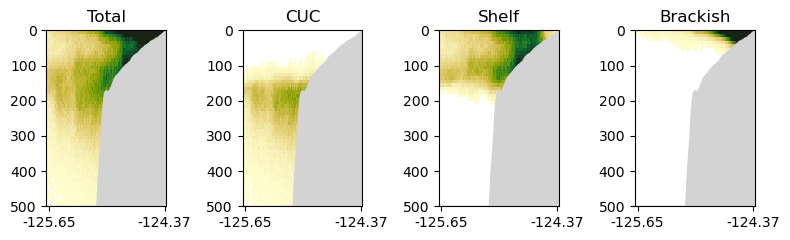

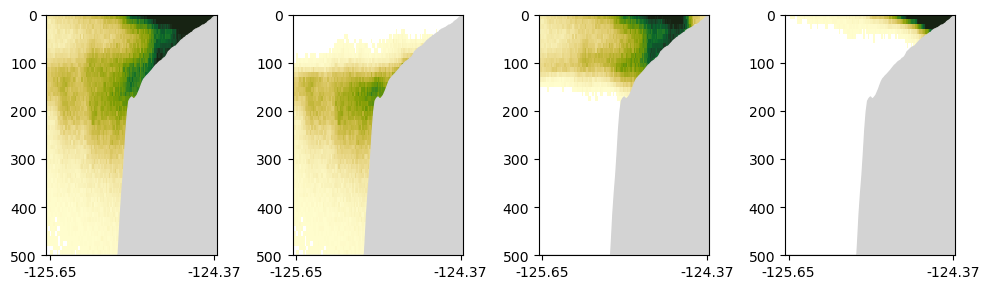

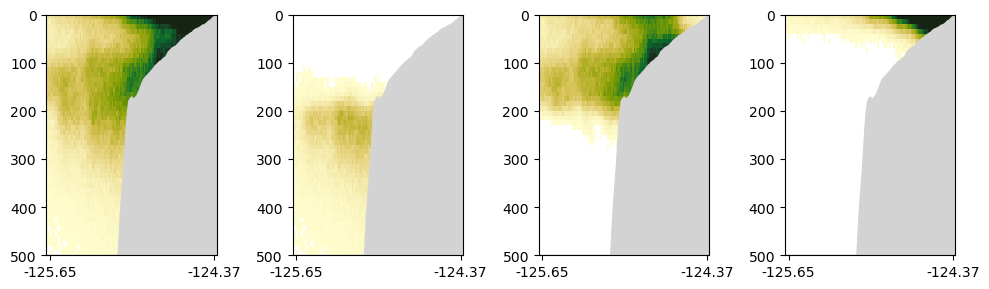

In [26]:
# location of cores of flow 
# dwWELLING
y = 744
xmin=192
xmax=317

############
# original #
############
figure, ax = plt.subplots(1,4,figsize=(8,2.5))
boolean = (dwdata.section == 2) #for all south
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[0])
ax[0].set_title('Total')

#try cuc delineation
boolean = (dwdata.section == 2) & (dwdata.salt >= 33.5)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[1])
ax[1].set_title('CUC')

#and south delineation
boolean = (dwdata.section == 2) & (dwdata.salt < 33.5) & (dwdata.salt >= 32)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[2])
ax[2].set_title('Shelf')

#and fresh delineation
boolean = (dwdata.section == 2) & (dwdata.salt < 32)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[3])
ax[3].set_title('Brackish')
plt.tight_layout()

#############
# minus 0.2 #
#############
figure, ax = plt.subplots(1,4,figsize=(10,3))
boolean = (dwdata.section == 2) #for all south
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[0])

#try cuc delineation
boolean = (dwdata.section == 2) & (dwdata.salt >= 33.5-0.2)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[1])

#and south delineation
boolean = (dwdata.section == 2) & (dwdata.salt < 33.5-0.2) & (dwdata.salt >= 32-0.2)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[2])

#and fresh delineation
boolean = (dwdata.section == 2) & (dwdata.salt < 32-0.2)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[3])
plt.tight_layout()

############
# plus 0.2 #
############
figure, ax = plt.subplots(1,4,figsize=(10,3))
boolean = (dwdata.section == 2) #for all south
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[0])

#try cuc delineation
boolean = (dwdata.section == 2) & (dwdata.salt >= 33.5+0.2)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[1])

#and south delineation
boolean = (dwdata.section == 2) & (dwdata.salt < 33.5+0.2) & (dwdata.salt >= 32+0.2)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[2])

#and fresh delineation
boolean = (dwdata.section == 2) & (dwdata.salt < 32+0.2)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax[3])
plt.tight_layout()


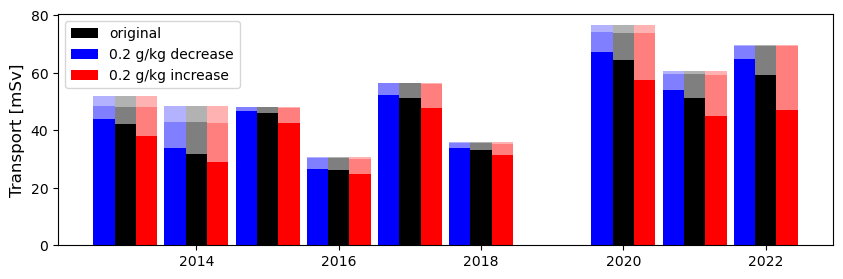

In [27]:
# annual transport from each watermass based on the three divisions
# upwelling
years = np.array(list(set(up.year)))
cuc = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >=33.5)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
cucpls = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >=33.5+0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
cucneg = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >=33.5-0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

she = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >= 32)&(updata.salt < 33.5)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
shepls = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >= 32+0.2)&(updata.salt < 33.5+0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
sheneg = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >= 32-0.2)&(updata.salt < 33.5-0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

fre = [np.sum(updata.transport[(updata.section == 2)&(updata.salt <32)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
frepls = [np.sum(updata.transport[(updata.section == 2)&(updata.salt <32+0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
freneg = [np.sum(updata.transport[(updata.section == 2)&(updata.salt <32-0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

fig, ax = plt.subplots(1,1,figsize=(10,3))

ax.bar(years,cuc,width=0.3,color='k',alpha=1,zorder=2,label='original')
ax.bar(years,she,width=0.3,color='k',alpha=0.5,bottom=cuc,zorder=2)
ax.bar(years,fre,width=0.3,color='k',alpha=0.3,bottom=np.sum([she,cuc],axis=0),zorder=2)

ax.bar(years-0.3,cucneg,width=0.3,color='b',alpha=1,zorder=2,label='0.2 g/kg decrease')
ax.bar(years-0.3,sheneg,width=0.3,color='b',alpha=0.5,bottom=cucneg,zorder=2)
ax.bar(years-0.3,freneg,width=0.3,color='b',alpha=0.3,bottom=np.sum([sheneg,cucneg],axis=0),zorder=2)

ax.bar(years+0.3,cucpls,width=0.3,color='r',alpha=1,zorder=2,label='0.2 g/kg increase')
ax.bar(years+0.3,shepls,width=0.3,color='r',alpha=0.5,bottom=cucpls,zorder=2)
ax.bar(years+0.3,frepls,width=0.3,color='r',alpha=0.3,bottom=np.sum([shepls,cucpls],axis=0),zorder=2)

# ax.set_xticks(tick_spots)
# ax.set_xticklabels(ticks, fontsize=12)
ax.set_ylabel('Transport [mSv]',fontsize=12)
ax.legend()

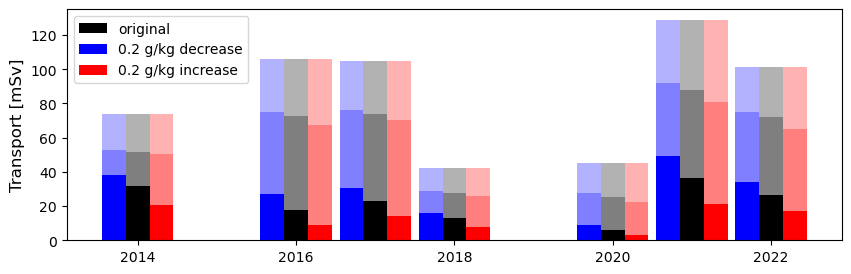

In [28]:
# annual transport from each watermass based on the three divisions
# downwelling
years = np.array(list(set(dw.year)))
cuc = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >=33.5)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
cucpls = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >=33.5+0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
cucneg = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >=33.5-0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

she = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >= 32)&(dwdata.salt < 33.5)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
shepls = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >= 32+0.2)&(dwdata.salt < 33.5+0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
sheneg = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >= 32-0.2)&(dwdata.salt < 33.5-0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

fre = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt <32)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
frepls = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt <32+0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
freneg = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt <32-0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

fig, ax = plt.subplots(1,1,figsize=(10,3))

ax.bar(years,cuc,width=0.3,color='k',alpha=1,zorder=2,label='original')
ax.bar(years,she,width=0.3,color='k',alpha=0.5,bottom=cuc,zorder=2)
ax.bar(years,fre,width=0.3,color='k',alpha=0.3,bottom=np.sum([she,cuc],axis=0),zorder=2)

ax.bar(years-0.3,cucneg,width=0.3,color='b',alpha=1,zorder=2,label='0.2 g/kg decrease')
ax.bar(years-0.3,sheneg,width=0.3,color='b',alpha=0.5,bottom=cucneg,zorder=2)
ax.bar(years-0.3,freneg,width=0.3,color='b',alpha=0.3,bottom=np.sum([sheneg,cucneg],axis=0),zorder=2)

ax.bar(years+0.3,cucpls,width=0.3,color='r',alpha=1,zorder=2,label='0.2 g/kg increase')
ax.bar(years+0.3,shepls,width=0.3,color='r',alpha=0.5,bottom=cucpls,zorder=2)
ax.bar(years+0.3,frepls,width=0.3,color='r',alpha=0.3,bottom=np.sum([shepls,cucpls],axis=0),zorder=2)

# ax.set_xticks(tick_spots)
# ax.set_xticklabels(ticks, fontsize=12)
ax.set_ylabel('Transport [mSv]',fontsize=12)
ax.legend()

In [29]:
# mSv change each year due to salinity definition
# total transport
tot = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
# print(tot)

# fresh division
print(np.mean((np.array(fre))))
print(np.mean((np.array(frepls)-np.array(fre))))
print(((np.array(frepls)-np.array(fre))/np.array(fre))*100)
print(np.mean((np.array(frepls)-np.array(fre))/np.array(fre))*100)


print(((np.array(fre)-np.array(freneg))/np.array(fre))*100)
print(np.mean((np.array(fre)-np.array(freneg))/np.array(fre))*100)
print('\n')
# south-fresh division
print(np.mean(np.array(she)))
print(((np.array(frepls)-np.array(fre))/np.array(she))*100)
print(np.mean((np.array(frepls)-np.array(fre))/np.array(she))*100)
print(((np.array(fre)-np.array(freneg))/np.array(she))*100)
print(np.mean((np.array(fre)-np.array(freneg))/np.array(she))*100)


27.28268230321265
4.017506512154708
[16.4362384  11.04137408 10.6794742  13.51271243 17.3092736  23.53648182
  4.54873655]
13.866327295920087
[ 7.60542742  7.02858727  8.04263908 12.18324631  9.6603933  10.26719455
  5.23661057]
8.574871213629653


36.69967710114457
[10.05180375  6.64414243 10.60475099 14.11406787 13.62414006 15.24317531
  4.98666952]
10.752678562083325
[ 4.65120194  4.22944957  7.98636555 12.72543659  7.6037016   6.64944946
  5.74076912]
7.0837676910725165


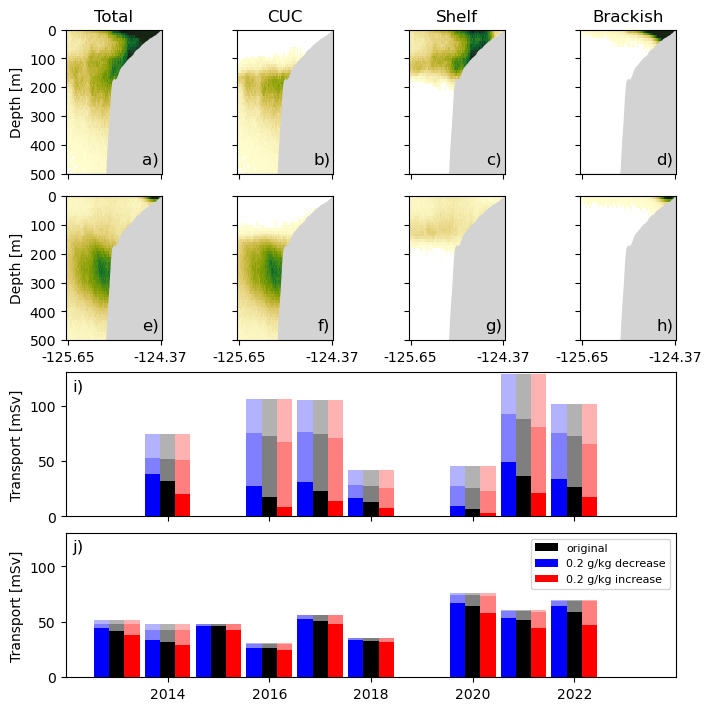

In [30]:
# one figure for paper 
fig = plt.figure(constrained_layout=True, figsize=[7,7])
gs = GridSpec(4, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])
ax9 = fig.add_subplot(gs[2, :])
ax10 = fig.add_subplot(gs[3, :])


# location of cores of flow 
y = 744
xmin=192
xmax=317

###############
# Downwelling #
###############

boolean = (dwdata.section == 2) #for all south
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax1)
ax1.set_title('Total')
ax1.set_xticklabels([])
ax1.set_ylabel('Depth [m]')

#try cuc delineation
boolean = (dwdata.section == 2) & (dwdata.salt >= 33.5)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax2)
ax2.set_title('CUC')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

#and south delineation
boolean = (dwdata.section == 2) & (dwdata.salt < 33.5) & (dwdata.salt >= 32)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax3)
ax3.set_title('Shelf')
ax3.set_xticklabels([])
ax3.set_yticklabels([])

#and fresh delineation
boolean = (dwdata.section == 2) & (dwdata.salt < 32)
FluxEW_ROMS(dwdata, boolean, y, xmin, xmax, ldw, ax4)
ax4.set_title('Brackish')
ax4.set_xticklabels([])
ax4.set_yticklabels([])

#############
# Upwelling #
#############

boolean = (updata.section == 2) #for all south
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax5)
ax5.set_ylabel('Depth [m]')

#try cuc delineation
boolean = (updata.section == 2) & (updata.salt >= 33.5)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax6)
ax6.set_yticklabels([])

#and south delineation
boolean = (updata.section == 2) & (updata.salt < 33.5) & (updata.salt >= 32)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax7)
ax7.set_yticklabels([])

#and fresh delineation
boolean = (updata.section == 2) & (updata.salt < 32)
FluxEW_ROMS(updata, boolean, y, xmin, xmax, lup, ax8)
ax8.set_yticklabels([])

# annual transport from each watermass based on the three divisions
# downwelling
years = np.array(list(set(dw.year)))
cuc = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >=33.5)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
cucpls = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >=33.5+0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
cucneg = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >=33.5-0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

she = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >= 32)&(dwdata.salt < 33.5)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
shepls = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >= 32+0.2)&(dwdata.salt < 33.5+0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
sheneg = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt >= 32-0.2)&(dwdata.salt < 33.5-0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

fre = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt <32)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
frepls = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt <32+0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
freneg = [np.sum(dwdata.transport[(dwdata.section == 2)&(dwdata.salt <32-0.2)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

ax9.bar(years,cuc,width=0.3,color='k',alpha=1,zorder=2,label='original')
ax9.bar(years,she,width=0.3,color='k',alpha=0.5,bottom=cuc,zorder=2)
ax9.bar(years,fre,width=0.3,color='k',alpha=0.3,bottom=np.sum([she,cuc],axis=0),zorder=2)

ax9.bar(years-0.3,cucneg,width=0.3,color='b',alpha=1,zorder=2,label='0.2 g/kg decrease')
ax9.bar(years-0.3,sheneg,width=0.3,color='b',alpha=0.5,bottom=cucneg,zorder=2)
ax9.bar(years-0.3,freneg,width=0.3,color='b',alpha=0.3,bottom=np.sum([sheneg,cucneg],axis=0),zorder=2)

ax9.bar(years+0.3,cucpls,width=0.3,color='r',alpha=1,zorder=2,label='0.2 g/kg increase')
ax9.bar(years+0.3,shepls,width=0.3,color='r',alpha=0.5,bottom=cucpls,zorder=2)
ax9.bar(years+0.3,frepls,width=0.3,color='r',alpha=0.3,bottom=np.sum([shepls,cucpls],axis=0),zorder=2)

ax9.set_xticklabels([])
ax9.set_ylabel('Transport [mSv]')
ax9.set_ylim([0,130])
ax9.set_xlim([2012,2024])
ax9.set_xticks([2014,2016,2018,2020,2022])

# UPWELLING

years = np.array(list(set(up.year)))
cuc = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >=33.5)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
cucpls = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >=33.5+0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
cucneg = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >=33.5-0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

she = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >= 32)&(updata.salt < 33.5)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
shepls = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >= 32+0.2)&(updata.salt < 33.5+0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
sheneg = [np.sum(updata.transport[(updata.section == 2)&(updata.salt >= 32-0.2)&(updata.salt < 33.5-0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

fre = [np.sum(updata.transport[(updata.section == 2)&(updata.salt <32)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
frepls = [np.sum(updata.transport[(updata.section == 2)&(updata.salt <32+0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
freneg = [np.sum(updata.transport[(updata.section == 2)&(updata.salt <32-0.2)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

ax10.bar(years,cuc,width=0.3,color='k',alpha=1,zorder=2,label='original')
ax10.bar(years,she,width=0.3,color='k',alpha=0.5,bottom=cuc,zorder=2)
ax10.bar(years,fre,width=0.3,color='k',alpha=0.3,bottom=np.sum([she,cuc],axis=0),zorder=2)

ax10.bar(years-0.3,cucneg,width=0.3,color='b',alpha=1,zorder=2,label='0.2 g/kg decrease')
ax10.bar(years-0.3,sheneg,width=0.3,color='b',alpha=0.5,bottom=cucneg,zorder=2)
ax10.bar(years-0.3,freneg,width=0.3,color='b',alpha=0.3,bottom=np.sum([sheneg,cucneg],axis=0),zorder=2)

ax10.bar(years+0.3,cucpls,width=0.3,color='r',alpha=1,zorder=2,label='0.2 g/kg increase')
ax10.bar(years+0.3,shepls,width=0.3,color='r',alpha=0.5,bottom=cucpls,zorder=2)
ax10.bar(years+0.3,frepls,width=0.3,color='r',alpha=0.3,bottom=np.sum([shepls,cucpls],axis=0),zorder=2)

ax10.set_ylabel('Transport [mSv]')
ax10.legend(fontsize=8)
ax10.set_ylim([0,130])
ax10.set_xlim([2012,2024])
ax10.set_xticks([2014,2016,2018,2020,2022])

# add text
letters = ['a)','b)','c)','d)','e)','f)','g)','h)']
i=0
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    ax.text(.97, .05, letters[i], ha='right', va='bottom', transform=ax.transAxes, fontsize=12)
    i+=1
ax9.text(.01, .85, 'i)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=12)
ax10.text(.01, .85, 'j)', ha='left', va='bottom', transform=ax10.transAxes, fontsize=12)

plt.savefig('/data1/bbeutel/LO_user/ariane/figures/southsensitivity.png')

## offshore water masses

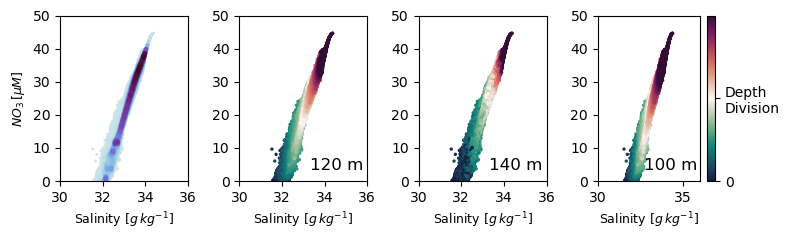

In [12]:
# and for downwelling 
fig, ax = plt.subplots(1,4, figsize=(8,2.5))
salt, temp, NO3, trans, depth = dwdata[dwdata.section == 3].salt.reset_index(drop=True), dwdata[dwdata.section == 3].temperature.reset_index(drop=True), dwdata[dwdata.section == 3].NO3.reset_index(drop=True), dwdata[dwdata.section == 3].transport.reset_index(drop=True), dwdata[dwdata.section == 3].depth.reset_index(drop=True)

# first TS coloured by transport
bins = [np.linspace(30,36,100),np.linspace(0,50,100)]
data, x_e, y_e = np.histogram2d(salt,NO3, bins = bins, density = True, weights=trans)
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,NO3]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, NO3, z = salt[idx], NO3[idx], z[idx]    
ax[0].scatter(salt,NO3, c=z, cmap=cm.cm.dense,s=1)
ax[0].set_ylabel('$NO_3 \,[\mu M$]', fontsize=9)
ax[0].set_ylim([np.min(bins[1]),np.max(bins[1])])
ax[0].set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax[1].scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=240)
# cb = fig.colorbar(sc, ax=ax[1])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
ax[1].set_ylim([np.min(bins[1]),np.max(bins[1])])
ax[1].set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth +20 m
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax[2].scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=280)
# cb = fig.colorbar(sc, ax=ax[2])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
ax[2].set_ylim([np.min(bins[1]),np.max(bins[1])])
ax[2].set_xlim([np.min(bins[0]),np.max(bins[0])])


# then coloured by depth -20 m
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax[3].scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
cb = fig.colorbar(sc, ax=ax[3])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
cb.set_ticks([0,100])
cb.set_ticklabels(['0','Depth\nDivision'])
ax[3].set_ylim([np.min(bins[1]),np.max(bins[1])])
ax[3].set_xlim([np.min(bins[0]),np.max(bins[0])])


for axs in ax:
    axs.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=9)

# add text about depth division to each plot
ax[1].text(.97, .05, '120 m', ha='right', va='bottom', transform=ax[1].transAxes, fontsize=12)
ax[2].text(.97, .05, '140 m', ha='right', va='bottom', transform=ax[2].transAxes, fontsize=12)
ax[3].text(.97, .05, '100 m', ha='right', va='bottom', transform=ax[3].transAxes, fontsize=12)


plt.tight_layout()

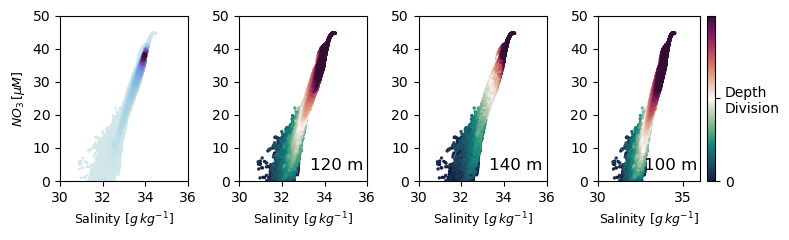

In [13]:
# and for upwelling 
fig, ax = plt.subplots(1,4, figsize=(8,2.5))
salt, temp, NO3, trans, depth = updata[updata.section == 3].salt.reset_index(drop=True), updata[updata.section == 3].temperature.reset_index(drop=True), updata[updata.section == 3].NO3.reset_index(drop=True), updata[updata.section == 3].transport.reset_index(drop=True), updata[updata.section == 3].depth.reset_index(drop=True)

# first TS coloured by transport
bins = [np.linspace(30,36,100),np.linspace(0,50,100)]
data, x_e, y_e = np.histogram2d(salt,NO3, bins = bins, density = True, weights=trans)
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,NO3]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, NO3, z = salt[idx], NO3[idx], z[idx]    
ax[0].scatter(salt,NO3, c=z, cmap=cm.cm.dense,s=1)
ax[0].set_ylabel('$NO_3 \,[\mu M$]', fontsize=9)
ax[0].set_ylim([np.min(bins[1]),np.max(bins[1])])
ax[0].set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax[1].scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=240)
# cb = fig.colorbar(sc, ax=ax[1])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
ax[1].set_ylim([np.min(bins[1]),np.max(bins[1])])
ax[1].set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth +20 m
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax[2].scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=280)
# cb = fig.colorbar(sc, ax=ax[2])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
ax[2].set_ylim([np.min(bins[1]),np.max(bins[1])])
ax[2].set_xlim([np.min(bins[0]),np.max(bins[0])])


# then coloured by depth -20 m
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax[3].scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
cb = fig.colorbar(sc, ax=ax[3])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
cb.set_ticks([0,100])
cb.set_ticklabels(['0','Depth\nDivision'])
ax[3].set_ylim([np.min(bins[1]),np.max(bins[1])])
ax[3].set_xlim([np.min(bins[0]),np.max(bins[0])])


for axs in ax:
    axs.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=9)

# add text about depth division to each plot
ax[1].text(.97, .05, '120 m', ha='right', va='bottom', transform=ax[1].transAxes, fontsize=12)
ax[2].text(.97, .05, '140 m', ha='right', va='bottom', transform=ax[2].transAxes, fontsize=12)
ax[3].text(.97, .05, '100 m', ha='right', va='bottom', transform=ax[3].transAxes, fontsize=12)


plt.tight_layout()

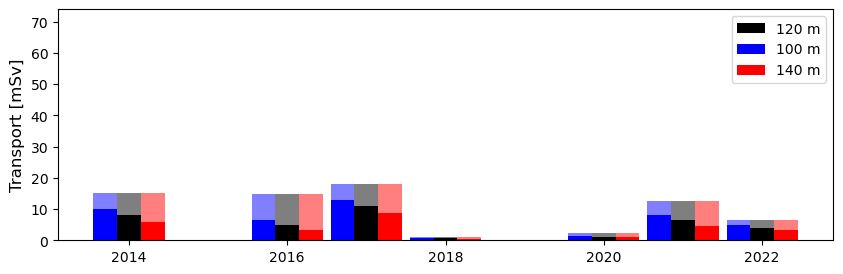

In [16]:
# annual transport from each watermass based on the depth divisions
# downwelling
years = np.array(list(set(dw.year)))
deep = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth >120)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
deeppls = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth >120+20)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
deepneg = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth >120-20)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

shal = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth <= 120)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
shalpls = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth <= 120+20)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
shalneg = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth <= 120-20)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]


fig, ax = plt.subplots(1,1,figsize=(10,3))

ax.bar(years,deep,width=0.3,color='k',alpha=1,zorder=2,label='120 m')
ax.bar(years,shal,width=0.3,color='k',alpha=0.5,bottom=deep,zorder=2)

ax.bar(years-0.3,deepneg,width=0.3,color='b',alpha=1,zorder=2,label='100 m')
ax.bar(years-0.3,shalneg,width=0.3,color='b',alpha=0.5,bottom=deepneg,zorder=2)

ax.bar(years+0.3,deeppls,width=0.3,color='r',alpha=1,zorder=2,label='140 m')
ax.bar(years+0.3,shalpls,width=0.3,color='r',alpha=0.5,bottom=deeppls,zorder=2)

# ax.set_xticks(tick_spots)
# ax.set_xticklabels(ticks, fontsize=12)
ax.set_ylabel('Transport [mSv]',fontsize=12)
ax.set_ylim([0,74])
ax.legend()

(0.0, 74.0)

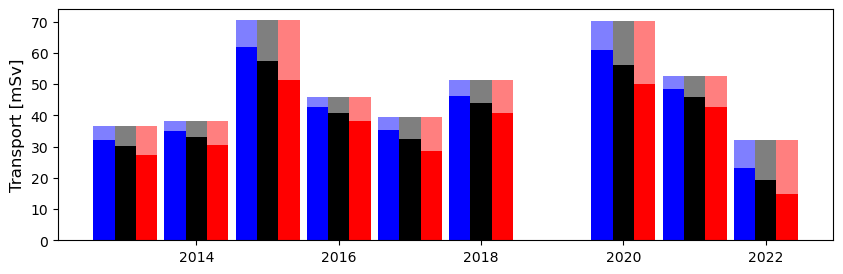

In [17]:
# annual transport from each watermass based on the depth divisions
# upwelling
years = np.array(list(set(up.year)))
deep = [np.sum(updata.transport[(updata.section == 3)&(updata.depth >120)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
deeppls = [np.sum(updata.transport[(updata.section == 3)&(updata.depth >120+20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
deepneg = [np.sum(updata.transport[(updata.section == 3)&(updata.depth >120-20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

shal = [np.sum(updata.transport[(updata.section == 3)&(updata.depth <= 120)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
shalpls = [np.sum(updata.transport[(updata.section == 3)&(updata.depth <= 120+20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
shalneg = [np.sum(updata.transport[(updata.section == 3)&(updata.depth <= 120-20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]


fig, ax = plt.subplots(1,1,figsize=(10,3))

ax.bar(years,deep,width=0.3,color='k',alpha=1,zorder=2,label='120 m')
ax.bar(years,shal,width=0.3,color='k',alpha=0.5,bottom=deep,zorder=2)

ax.bar(years-0.3,deepneg,width=0.3,color='b',alpha=1,zorder=2,label='100 m')
ax.bar(years-0.3,shalneg,width=0.3,color='b',alpha=0.5,bottom=deepneg,zorder=2)

ax.bar(years+0.3,deeppls,width=0.3,color='r',alpha=1,zorder=2,label='140 m')
ax.bar(years+0.3,shalpls,width=0.3,color='r',alpha=0.5,bottom=deeppls,zorder=2)

# ax.set_xticks(tick_spots)
# ax.set_xticklabels(ticks, fontsize=12)
ax.set_ylabel('Transport [mSv]',fontsize=12)
# ax.legend()
ax.set_ylim([0,74])

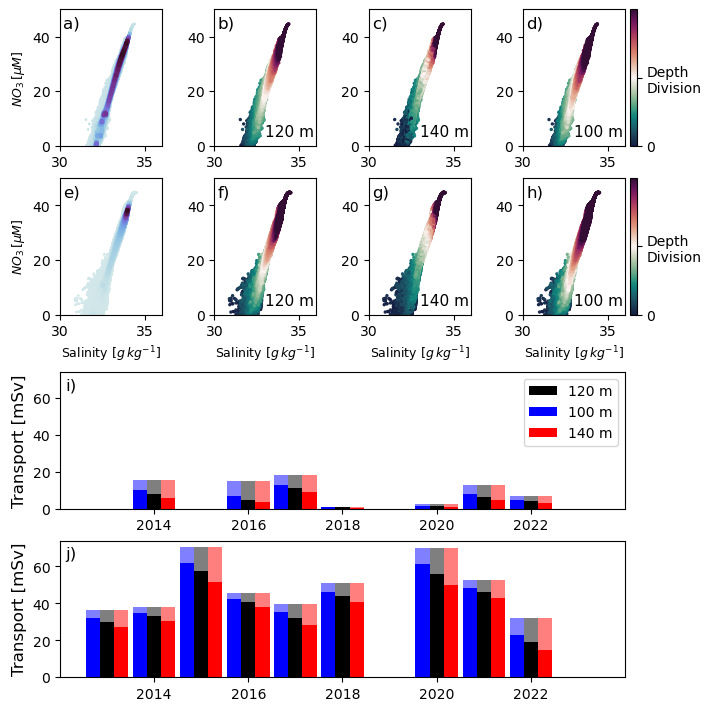

In [21]:
# all together now 
fig = plt.figure(constrained_layout=True, figsize=[7,7])
gs = GridSpec(4, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])
ax9 = fig.add_subplot(gs[2, :])
ax10 = fig.add_subplot(gs[3, :])

##########
# NO3-SA #
##########

# DOWNWELLING
salt, NO3, trans, depth = dwdata[dwdata.section == 3].salt.reset_index(drop=True), dwdata[dwdata.section == 3].NO3.reset_index(drop=True), dwdata[dwdata.section == 3].transport.reset_index(drop=True), dwdata[dwdata.section == 3].depth.reset_index(drop=True)

# first TS coloured by transport
bins = [np.linspace(30,36,100),np.linspace(0,50,100)]
data, x_e, y_e = np.histogram2d(salt,NO3, bins = bins, density = True, weights=trans)
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,NO3]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, NO3, z = salt[idx], NO3[idx], z[idx]    
ax1.scatter(salt,NO3, c=z, cmap=cm.cm.dense,s=1)
ax1.set_ylabel('$NO_3 \,[\mu M$]', fontsize=9)
ax1.set_ylim([np.min(bins[1]),np.max(bins[1])])
ax1.set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax2.scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=240)
# cb = fig.colorbar(sc, ax=ax[1])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
ax2.set_ylim([np.min(bins[1]),np.max(bins[1])])
ax2.set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth +20 m
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax3.scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=280)
# cb = fig.colorbar(sc, ax=ax[2])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
ax3.set_ylim([np.min(bins[1]),np.max(bins[1])])
ax3.set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth -20 m
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax4.scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
cb = fig.colorbar(sc, ax=ax4)
cb.set_ticks([0,100])
cb.set_ticklabels(['0','Depth\nDivision'])
ax4.set_ylim([np.min(bins[1]),np.max(bins[1])])
ax4.set_xlim([np.min(bins[0]),np.max(bins[0])])

#UPWELLING
salt, NO3, trans, depth = updata[updata.section == 3].salt.reset_index(drop=True), updata[updata.section == 3].NO3.reset_index(drop=True), updata[updata.section == 3].transport.reset_index(drop=True), updata[updata.section == 3].depth.reset_index(drop=True)

# first TS coloured by transport
bins = [np.linspace(30,36,100),np.linspace(0,50,100)]
data, x_e, y_e = np.histogram2d(salt,NO3, bins = bins, density = True, weights=trans)
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,NO3]).T ,method = "splinef2d", bounds_error = False)
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
salt, NO3, z = salt[idx], NO3[idx], z[idx]    
ax5.scatter(salt,NO3, c=z, cmap=cm.cm.dense,s=1)
ax5.set_ylabel('$NO_3 \,[\mu M$]', fontsize=9)
ax5.set_ylim([np.min(bins[1]),np.max(bins[1])])
ax5.set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax6.scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=240)
# cb = fig.colorbar(sc, ax=ax[1])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
ax6.set_ylim([np.min(bins[1]),np.max(bins[1])])
ax6.set_xlim([np.min(bins[0]),np.max(bins[0])])

# then coloured by depth +20 m
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax7.scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=280)
# cb = fig.colorbar(sc, ax=ax[2])
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
ax7.set_ylim([np.min(bins[1]),np.max(bins[1])])
ax7.set_xlim([np.min(bins[0]),np.max(bins[0])])


# then coloured by depth -20 m
cmap = cm.cm.curl
idx = depth.argsort()
salt, NO3, depth = salt[idx], NO3[idx], depth[idx]
sc=ax8.scatter(salt,NO3,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
cb = fig.colorbar(sc, ax=ax8)
# cb.set_label('Depth [m]', labelpad=10, fontsize=10)
cb.set_ticks([0,100])
cb.set_ticklabels(['0','Depth\nDivision'])
ax8.set_ylim([np.min(bins[1]),np.max(bins[1])])
ax8.set_xlim([np.min(bins[0]),np.max(bins[0])])

for axs in [ax5,ax6,ax7,ax8]:
    axs.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=9)

# add text about depth division to each plot
ax2.text(.98, .05, '120 m', ha='right', va='bottom', transform=ax2.transAxes, fontsize=11)
ax3.text(.98, .05, '140 m', ha='right', va='bottom', transform=ax3.transAxes, fontsize=11)
ax4.text(.98, .05, '100 m', ha='right', va='bottom', transform=ax4.transAxes, fontsize=11)
ax6.text(.98, .05, '120 m', ha='right', va='bottom', transform=ax6.transAxes, fontsize=11)
ax7.text(.98, .05, '140 m', ha='right', va='bottom', transform=ax7.transAxes, fontsize=11)
ax8.text(.98, .05, '100 m', ha='right', va='bottom', transform=ax8.transAxes, fontsize=11)

#######################
# Change in Transport #
#######################

# downwelling
years = np.array(list(set(dw.year)))
deep = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth >120)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
deeppls = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth >120+20)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
deepneg = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth >120-20)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

shal = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth <= 120)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
shalpls = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth <= 120+20)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]
shalneg = [np.sum(dwdata.transport[(dwdata.section == 3)&(dwdata.depth <= 120-20)&(dwdata.year == years[i])])/(ldw[i]*24)/1000 for i in range(len(years))]

ax9.bar(years,deep,width=0.3,color='k',alpha=1,zorder=2,label='120 m')
ax9.bar(years,shal,width=0.3,color='k',alpha=0.5,bottom=deep,zorder=2)

ax9.bar(years-0.3,deepneg,width=0.3,color='b',alpha=1,zorder=2,label='100 m')
ax9.bar(years-0.3,shalneg,width=0.3,color='b',alpha=0.5,bottom=deepneg,zorder=2)

ax9.bar(years+0.3,deeppls,width=0.3,color='r',alpha=1,zorder=2,label='140 m')
ax9.bar(years+0.3,shalpls,width=0.3,color='r',alpha=0.5,bottom=deeppls,zorder=2)

ax9.set_ylabel('Transport [mSv]',fontsize=12)
ax9.set_ylim([0,74])
ax9.set_xlim([2012,2024])
ax9.set_xticks([2014,2016,2018,2020,2022])
ax9.legend()

# upwelling

years = np.array(list(set(up.year)))
deep = [np.sum(updata.transport[(updata.section == 3)&(updata.depth >120)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
deeppls = [np.sum(updata.transport[(updata.section == 3)&(updata.depth >120+20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
deepneg = [np.sum(updata.transport[(updata.section == 3)&(updata.depth >120-20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

shal = [np.sum(updata.transport[(updata.section == 3)&(updata.depth <= 120)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
shalpls = [np.sum(updata.transport[(updata.section == 3)&(updata.depth <= 120+20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]
shalneg = [np.sum(updata.transport[(updata.section == 3)&(updata.depth <= 120-20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))]

ax10.bar(years,deep,width=0.3,color='k',alpha=1,zorder=2,label='120 m')
ax10.bar(years,shal,width=0.3,color='k',alpha=0.5,bottom=deep,zorder=2)

ax10.bar(years-0.3,deepneg,width=0.3,color='b',alpha=1,zorder=2,label='100 m')
ax10.bar(years-0.3,shalneg,width=0.3,color='b',alpha=0.5,bottom=deepneg,zorder=2)

ax10.bar(years+0.3,deeppls,width=0.3,color='r',alpha=1,zorder=2,label='140 m')
ax10.bar(years+0.3,shalpls,width=0.3,color='r',alpha=0.5,bottom=deeppls,zorder=2)

ax10.set_ylabel('Transport [mSv]',fontsize=12)
ax10.set_ylim([0,74])
ax10.set_xlim([2012,2024])
ax10.set_xticks([2014,2016,2018,2020,2022])


# add text
letters = ['a)','b)','c)','d)','e)','f)','g)','h)']
i=0
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    ax.text(.03, .95, letters[i], ha='left', va='top', transform=ax.transAxes, fontsize=12)
    i+=1
ax9.text(.01, .85, 'i)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=12)
ax10.text(.01, .85, 'j)', ha='left', va='bottom', transform=ax10.transAxes, fontsize=12)

plt.savefig('/data1/bbeutel/LO_user/ariane/figures/offshoresensitivity.png')

In [38]:
# change between deep and shallow 
# during upwelling
# 100 versu 120 m 

deep = np.array([np.sum(updata.transport[(updata.section == 3)&(updata.depth >120)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))])
deepneg = np.array([np.sum(updata.transport[(updata.section == 3)&(updata.depth >120-20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))])

shal = np.array([np.sum(updata.transport[(updata.section == 3)&(updata.depth <= 120)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))])
shalneg = np.array([np.sum(updata.transport[(updata.section == 3)&(updata.depth <= 120-20)&(updata.year == years[i])])/(lup[i]*24)/1000 for i in range(len(years))])

total = np.sum([deep,shal],axis=0)

print(np.mean(shal-shalneg))
print(np.mean(shal))
print(np.mean(deep))
print(np.mean(total))

3.009396067938736
8.643329367832674
39.8989703627856
48.54229973061827
